In [1]:
from pycromanager import Bridge
import imagej
from skimage import io as skio
import pickle
import os.path as path
import os
import numpy as np
from tqdm import tqdm
from smartpath_libraries.sp_stitcher import SPStitcher

In [2]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()
ij = imagej.init('fiji\\fiji\\Fiji.app')
core.set_timeout_ms(20000)
print("Succeeded!")

Succeeded!


In [3]:
from smartpath_libraries.sp_acquisition import SPAcquisition

In [7]:
sp_acq = SPAcquisition(
    config={**user_config, **model_config, **hard_config},
    mmcore=core, 
    mmstudio=studio,
    bf_4x_bg=skio.imread('data/presets/BG_4x.tiff'),
    bf_20x_bg=skio.imread('data/presets/BG_20x.tiff'),
    )

Load LSM presets.


In [8]:
save_path = 'data/acquisition'

acq_name = 'test0620' # No Spaces in name! Use - or _ No `ome` in name!

slide_box = (2000, 5000, 9000, 15000)

In [9]:
acq_name_4x = acq_name + '-4x-bf'
sp_acq.update_slide_box(slide_box)

In [10]:
sp_acq.switch_mod(mod='bf')
sp_acq.switch_objective(mag='4x')

Imaging objective set as 4x
Imaging mode set as Brightfield


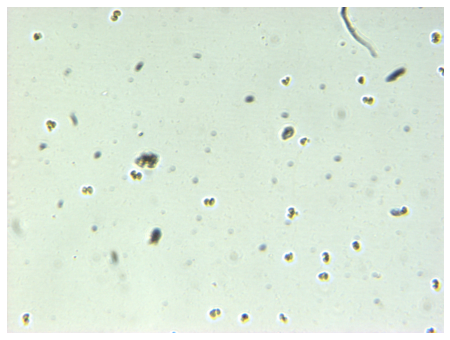

In [13]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [14]:
sp_acq.update_focus_presets(mag='4x', mod='bf')

 36/36 tiles done

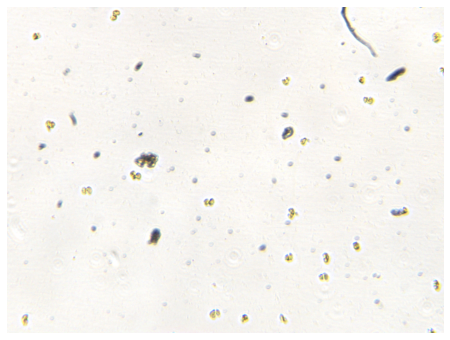

In [17]:
### perform the scan
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x
results_4x = sp_acq.whole_slide_bf_scan(
    save_path, 
    acq_name_4x, 
    position_list_4x.reshape(position_list_4x.shape[0]*position_list_4x.shape[1], -1), 
    mag='4x',
    focus_dive=True,
    estimate_background=False,
    )
### save background image and z positions, and position_list
results_4x['Position list'] = position_list_4x
sp_acq.z_list_4x = results_4x['Z positions']
with open(path.join(save_path, acq_name_4x+'.pkl'), 'wb') as f:
    pickle.dump(results_4x, f)

In [20]:
sp_sti = SPStitcher(
    config={**user_config, **model_config, **hard_config}, 
    ij=ij,
    working_dir=save_path,
    qupath_dir=os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe'), # os.sep does matter!!!
    )

In [14]:
position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
sp_sti.stitch_bf(
    acq_name_4x,
    mag='4x',
    position_list=position_list,
    flip_y=True,
    correction=False, # this should be set `True` if the default background image was not given during the acquisition
    background_image=None # this should be given as `loaded_results_4x['Background image']` `correction` is `True`
    )
sp_sti.convert_slide(mag='4x')
### optional clean the intermediate stitching files
sp_sti.clean_folders(acq_name_4x)

 Processing tiles: 36/36
 Calling ImageJ for titching, please wait...


[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-4x-bf\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (5770 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-4x-bf\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (161 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\tes

Converting slide to ome.tif


In [41]:
sp_acq.switch_mod(mod='bf')
sp_acq.switch_objective(mag='20x')

Imaging objective set as 20x
Imaging mode set as Brightfield
Imaging objective set as 20x


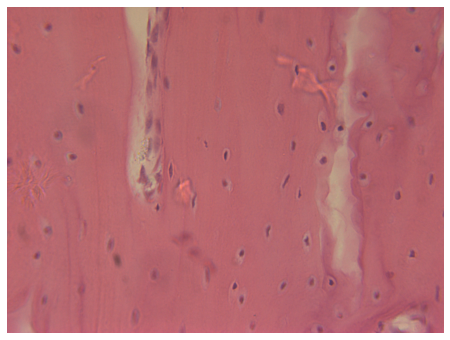

In [11]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [12]:
sp_acq.update_focus_presets(mag='20x', mod='bf')

In [30]:
### change autofocus speed in case
sp_acq.config["autofocus-speed"] = 3 # changed, was 3

In [31]:
### load 4x results from disk
with open(path.join(save_path, acq_name_4x+'.pkl'), 'rb') as f:
    loaded_results_4x = pickle.load(f)
sp_acq.position_list_4x = loaded_results_4x['Position list']
sp_acq.z_list_4x = loaded_results_4x['Z positions']
position_list_xyz = np.concatenate((   
    sp_acq.position_list_4x, 
    sp_acq.z_list_4x.reshape((sp_acq.position_list_4x.shape[0], sp_acq.position_list_4x.shape[1], 1))
    ), 2)
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')

 Processing tiles: 8/8
 Calling ImageJ for titching, please wait...


[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-20x--3415_4071\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (176 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-20x--3415_4071\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (174 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\st

Converting slide to ome.tif


1it [00:41, 41.14s/it]


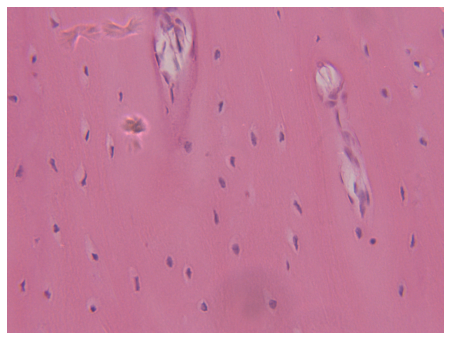

In [34]:
### perform the scan
sp_acq.position_list_20x = []
sp_acq.z_list_20x = []
for idx, (roi_pos, roi_name) in tqdm(enumerate(zip(position_lists_20x, annotation_names))):
    current_acq_name = acq_name + '-20x-' + annotation_names[idx]
    sampled_pos_xyz = sp_acq.resample_z_pos(mag='20x', xy_pos=roi_pos, xyz_pos_list_4x=position_list_xyz)
    results_20x = sp_acq.whole_slide_bf_scan(
        save_path, 
        current_acq_name, 
        sampled_pos_xyz, 
        mag='20x',
        focus_dive=True,
        estimate_background=False,
        )
    sp_acq.position_list_20x.append(sampled_pos_xyz)
    sp_acq.z_list_20x.append(results_20x['Z positions'])
    ### save background image and z positions, and position_list
    position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
    sp_sti.stitch_bf(
        current_acq_name,
        mag='20x',
        position_list=sampled_pos_xyz,
        flip_y=True,
        correction=False, 
        background_image=None 
        )
    sp_sti.convert_slide(mag='20x')
    # sp_sti.clean_folders(current_acq_name) # optional
np.save(os.path.join(save_path, acq_name +'-20x'+'-z_pos.npy'), sp_acq.z_list_20x, allow_pickle=True)

In [22]:
sp_acq.config["lsm-scan-rate"] = '250000.0000' #
sp_acq.config["lsm-pc-power"] = 0.75 # 0.6
sp_acq.config["lsm-pmt-gain"] = 0.6 # 0.6
sp_acq.config["lsm-bin-factor"] = 15
sp_acq.config["snr-level"] = 'mid'
sample_depth=14 # changed, was 14
z_step=7 # changed, was 7

In [42]:
sp_acq.switch_mod(mod='shg')
sp_acq.switch_objective(mag='20x')

Imaging mode set as SHG
Imaging objective set as 20x


In [43]:
position_lists_mp, annotation_mp = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='mp')
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
return_20x_list = np.load(os.path.join(save_path, acq_name+'-20x'+'-z_pos.npy'), allow_pickle=True).tolist()
return_20x_list = np.vstack(return_20x_list)
map_xyz_20x = np.concatenate((np.hstack(position_lists_20x), return_20x_list.reshape((return_20x_list.shape[0], 1))), 1)
for idx, (roi_pos, roi_name) in enumerate(zip(position_lists_mp, annotation_mp)):
    current_acq_name = acq_name + '-lsm-' + roi_name
    # sp_acq.switch_mod(mod='shg')
    # sp_acq.switch_objective(mag='20x')
    roi_pos[:, 0] = roi_pos[:, 0] #- 2907
    roi_pos[:, 1] = roi_pos[:, 1] #+ 3183 # changed, should be commented out
    sampled_pos_xyz_mp = sp_acq.resample_z_pos(mag='mp', xy_pos=roi_pos, xyz_pos_list_20x=map_xyz_20x)
    sp_acq.whole_slide_lsm_scan(
        save_path, 
        acq_name=current_acq_name, 
        position_list=sampled_pos_xyz_mp, 
        z_stack=True, 
        sample_depth=sample_depth, 
        z_step=z_step
        )
    num_channel = int(sample_depth/z_step)+1
    sp_sti.stitch_lsm(
        save_path, 
        current_acq_name, 
        n_stack=3, 
        position_list=sampled_pos_xyz_mp, 
        flip_y=False, 
        rotate=270, 
        correction=None
        )
    sp_sti.convert_slide(mag='mp')
    # sp_sti.clean_folders(current_acq_name) # optional

Dataset opened                 
 Processing tiles: 27/27Calling ImageJ for stitching, please wait...


[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-lsm--3415_4071\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 256x256px, channels=3, timepoints=1 (56 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-lsm--3415_4071\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 256x256px, channels=3, timepoints=1 (53 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitchin

Converting slide to ome.tif


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'data/stitching/tiles\\test0620-lsm--3415_4071\\TileConfiguration.txt'

In [44]:
num_channel = int(sample_depth/z_step)+1
sp_sti.stitch_lsm(
    save_path, 
    current_acq_name, 
    n_stack=3, 
    position_list=sampled_pos_xyz_mp, 
    flip_y=False, 
    rotate=270, 
    correction=None
    )
sp_sti.convert_slide(mag='mp')

Dataset opened                 
 Processing tiles: 27/27Calling ImageJ for stitching, please wait...


[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-lsm--3415_4071\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 256x256px, channels=3, timepoints=1 (186 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitching\tiles\test0620-lsm--3415_4071\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 256x256px, channels=3, timepoints=1 (51 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: f:\Documents\sp-project\data\stitchi

Converting slide to ome.tif


In [6]:
user_config = {
    
    ### User configuration ###
    
    # Quick configuration group for LSM
    "exposure-level" : 'high',
    # 'low'     -> scan rate: '500000.0000', pockel cell gain: 0.30, PMT gain: 0.40
    # 'mid'     -> scan rate: '400000.0000', pockel cell gain: 0.45, PMT gain: 0.45
    # 'high'    -> scan rate: '250000.0000', pockel cell gain: 0.60, PMT gain: 0.50
    # 'extreme' -> scan rate: '200000.0000', pockel cell gain: 0.75, PMT gain: 0.55
    
    "snr-level" : 'low',
    # Estimiated correction according to sample SNR level. Available value: 'low', 'mid', 'high', by default raw data is collected
    
    "autofocus-speed" : 3,
    # Speed of software autofocus, integer: 1~5. Bigger value leads to faster brightfield scan but potentially lower autofocus performance
       
    "lsm-resolution" : 256, 
    # LSM scan resolution, available resolution: 256, 512, 1024
    
    "lsm-bin-factor" : 15,
    # LSM scan pixel average factor, positive integer
    
    "lsm-scan-rate" : '250000.0000', 
    # LSM scan rate, available value (string): '125000.0000', '200000.0000', '250000.0000','400000.0000', '500000.0000', '625000.0000', '1000000.0000'
    
    "lsm-pc-power" : 0.4, 
    # LSM pockel cell gain, float point value: 0.0 ~ 1.0
    
    "lsm-pmt-gain" : 0.4,
    # LSM PMT gain, float point value: 0.0 ~ 1.0
    
    "slide-box" : (-100, 600, 25500.0, 17000.0), 
    # Pre-define scan area (read out values from the stage): (start x stage position, start y stage position, end x stage position, end y stage position)
    
    "lsm-enhancer" : None,
    
    "bf-enhancer" : None,
    
    "classifier" : None,
    # Automatic target detection model, available value (string or None): 'MIL', 'Supervised', None 
    
}

model_config = {
    
    "gpu" : False,
    # Is GPU available? Available value (boolean): True, False
    
    "batch-size" : 32,
    # Is GPU available? Available value (boolean): True, False 
    
    ### configure enhancer ###
    
    "image-channel" : 1,
    
    "dropout-rate" : 0.1, 
    
    "cnn-base-channel" : 4,
    
    "normalization" : None,
    # CNN normalization layere type
    
    "norm-range" : (13251, 63085),
    # Image normalization range, determined via *_dataset_preprocessing.ipynb in lsm-run-time-enhancement repo
         
    
    "dimension" : '2D',
    
    ### configure classifier
    
    "classifier-backbone" : 'ResNet18',
    # Backbone for CNN model, available value (string): 'ResNet18', 'ResNet34' 
    
    "classifier-num-class" : 2,
    # Number of class for the detector, non-zero integer
    
    "mil-classifier-thresh" : 2,
    # Threshold for MIL classifier. Obtained from training.
    
    "slide-type" : 'TMA',
    # Type of image the inference is applied, available value (string): "TMA", "slide"      

}

### right general save range check function
hard_config = {
    ### Hard configuration, 
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
#     "Z-stage-20x" : -6930, # -6930 + 290 / 10500
    "Z-stage-20x" : -6980, # -6930 + 290 / 10500
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15800, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "Z-bf-offset" : -10500,
    "Z-laser-offset" : 290,
    "hard-limit-z" : (-8500.0, 17000.0),
    "hard-limit-x" : (-5000.0, 40000.0),
    "hard-limit-y" : (-4200, 25000.0), #(-2200, 19000.0)
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}